In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy import stats
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import cross_val_predict
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import *
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.model_selection import train_test_split
%matplotlib inline
%precision %.2f
pd.options.display.float_format = '{:,.2f}'.format

/home/caitlin/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load, join, and clean data ##

In [2]:
#ProPublica data from here https://projects.propublica.org/colleges
#Not used in this analysis - but maybe would be better?

pp=pd.read_csv("ProPublica_Data.csv")
pp.head()

,State,Percentage of Pell Grantees,Median Federal Debt for All Students,Median Federal Debt of Pell Grantees,Nonrepayment Rate for Pell Students,Nonrepayment Rate for All Students,"Average Cost for Low-Income Students, Per Year",Default Rate for All Students,"Percentage of All Students Earning $25K or Less Per Year, 10 Years After Enrolling"
0,Adelphi University,0.31,"25,000.00","23,000.00",0.36,0.30,"22,197.00",0.03,0.20
1,Alliant International University-San Diego,0.12,"3,000.00","13,425.00",0.63,0.50,"16,785.00",0.03,0.20
2,American International College,0.51,"27,000.00","21,750.00",0.59,0.52,"17,160.00",0.06,0.26
3,American University,0.17,"24,589.00","25,000.00",0.27,0.20,"28,524.00",0.02,0.17
4,Andrews University,0.29,"27,750.00","26,768.00",0.54,0.49,"19,226.00",0.05,0.34


In [3]:
usnews = pd.read_csv("USNewsCollegeRankings2018.csv")
usnews.set_index('University', inplace=True)
usnews.head()

,City,State,Rank,In-state Tuition,Out-state Tuition,Enrollment
University,,,,,,
Princeton University,Princeton,NJ,1,$47140,$47140,"5,400.00"
Harvard University,Cambridge,MA,2,$48949,$48949,"6,710.00"
University of Chicago,Chicago,IL,3,$54825,$54825,"5,941.00"
Yale University,New Haven,CT,3,$51400,$51400,"5,472.00"
Columbia University,New York,NY,5,$57208,$57208,"6,113.00"


In [4]:
scorecard = pd.read_csv("MERGED2015_16_PP.csv")
scorecard.shape

/home/caitlin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (6,9,1725,1726,1727,1728,1729,1743) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(7593, 1777)

In [5]:
usnews=usnews[usnews['Rank']!= 'Rank Not Published']
usnews=usnews[usnews['Rank']!= 'Unranked']
usnews.shape

(230, 6)

In [8]:
scorecard.columns.values


array(['UNITID', 'OPEID', 'OPEID6', ..., 'UGNONDS', 'GRADS', 'ACCREDCODE'], dtype=object)

In [9]:
drop=['UNITID','OPEID','OPEID6','CITY','STABBR','ZIP','ACCREDAGENCY','INSTURL','NPCURL']
scorecard.drop(drop, axis=1, inplace=True)
scorecard.set_index('INSTNM',inplace=True)
scorecard = scorecard.loc[usnews.index]
scorecard['Rank']=usnews['Rank']
scorecard.shape

(230, 1768)

In [10]:
# scorecard.dropna(axis=1,thresh=100).shape
data = scorecard.dropna(thresh=100, axis=1).dropna(thresh=500)
for c in data.columns.values:
    data[c] = pd.to_numeric(data[c], errors='coerce')
data.dropna(axis=1,thresh=100, inplace=True)
# data.fillna(data.mean, inplace=True)
cols=[]
for c in data.columns.values:
    if data[c].var()!=0:
       cols.append(c)
data=data[cols]
data.shape

(142, 441)

In [11]:
def normalize(df):
    return(df - df.mean()) / df.std()

scnorm = normalize(data)

## Feature Analysis ##

In [12]:
#Find features that are correlated
names = pd.read_csv('col_names.csv')

#Remember that rankings are inverted - #1 best

pos_corr_features = []
neg_corr_features = []

for c in data.columns.values:
    corr, p = stats.pearsonr(data[c], data['Rank'])
    if p <0.05 and corr > 0.6 :
        pos_corr_features.append([names[names['VARIABLE NAME']==c]['developer-friendly name'].max(),c, corr,p])

for c in data.columns.values:
    corr, p = stats.pearsonr(data[c], data['Rank'])
    if p <0.05 and corr <-0.6 :
        neg_corr_features.append([names[names['VARIABLE NAME']==c]['developer-friendly name'].max(),c, corr,p])

print "Negatively correlated features"
print
for i in neg_corr_features:
    print i
print
print "Positively correlated features"
print
for i in pos_corr_features:
    print i


SyntaxError: Missing parentheses in call to 'print'. Did you mean print("Negatively correlated features")? (<ipython-input-12-263a30b940d8>, line 19)

## We choose the Pell grant rate as our protected attribute.##

This metric is related to family income levels, and is negatively correlated with the college rankings

And has been used to evaluate success of members of low income housholds in college

http://time.com/money/4981302/low-income-students-pell-graduate/

In [13]:
scnorm.sort_index(inplace=True)
# create groups based on median family income - high, low
groups = pd.DataFrame()
groups['PCTPELL']= data['PCTPELL']
data.drop(['PCTPELL'], axis=1, inplace=True)
m = groups['PCTPELL'].mean()
groups.loc[groups['PCTPELL'] >m,'Group'] = 1 #many grants
groups.loc[groups['PCTPELL'] <=m,'Group'] = 0 #few grants
X = np.nan_to_num(scnorm.drop(['Rank'], axis=1))
y = np.nan_to_num(scnorm['Rank'])
g=groups['Group']
# groups.head()

In [14]:
import pickle
pickle.dump( X, open( "x.p", "wb" ) )
pickle.dump( y, open( "y.p", "wb" ) )
pickle.dump( g, open( "g.p", "wb" ) )

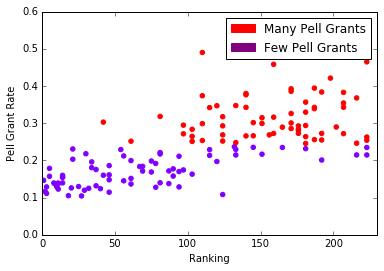

In [44]:
cmap = plt.cm.rainbow
plt.rcParams['figure.figsize'] = (6, 4)
fig, ax = plt.subplots()
ax.scatter(data['Rank'],groups['PCTPELL'], color=cmap((groups['Group'])))
ax.set_xlabel('Ranking')
ax.set_ylabel('Pell Grant Rate')
ax.set_xlim([0,230])
# ax.set_title('Relationship between Pell Grant Rate and College Ranking')
import matplotlib.patches as mpatches
col=cmap([0,1])
p0 = mpatches.Patch(color='Red', label='Many Pell Grants')
p1 = mpatches.Patch(color='Purple', label='Few Pell Grants')
plt.legend(handles =[p0, p1])

plt.show()

## Predict ##

In [45]:
lr = linear_model.LinearRegression()
abl = AdaBoostRegressor(linear_model.LinearRegression(), n_estimators=300, random_state=25)
dt = DecisionTreeRegressor(max_depth=4)
abt = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=300, random_state=25)
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
pred = cross_val_predict(lr, X, y, cv=10)
pred_abl = cross_val_predict(abl, X, y, cv=10)
pred_dt = cross_val_predict(dt, X, y, cv=10)
pred_abt = cross_val_predict(abt, X, y, cv=10)
print("Overall MSE: ",  mean_squared_error(y, pred))
print("Overall MSE: ",  mean_squared_error(y, pred_abl))
print("Overall MSE: ",  mean_squared_error(y, pred_dt))
print("Overall MSE: ",  mean_squared_error(y, pred_abt))

('Overall MSE: ', 0.10939310517587331)
('Overall MSE: ', 0.068308712453891349)
('Overall MSE: ', 0.15748923969055789)
('Overall MSE: ', 0.074239398147273511)


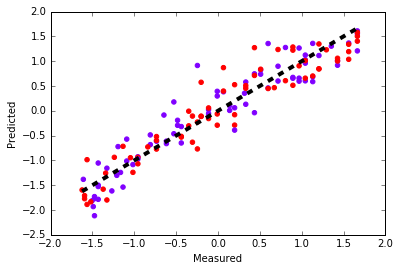

NameError: name 'pred_ab' is not defined

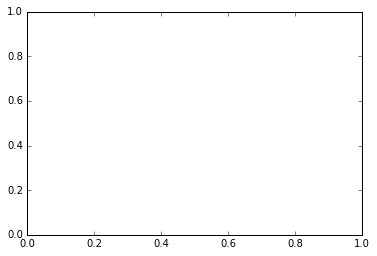

In [46]:
#plot linear regression
fig, ax = plt.subplots()
ax.scatter(y, pred, color=cmap((groups['Group'])))
minD = min(y.min(), pred.min())
maxD = max(y.max(),pred.max())
ax
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

fig, ax = plt.subplots()
ax.scatter(y, pred_ab, color=cmap((groups['Group'])))
minD = min(y.min(), pred_ab.min())
maxD = max(y.max(),pred_ab.max())
ax
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

print("Overall MSE: ",  mean_squared_error(y, pred))
print("Overall MSE: ",  mean_squared_error(y, pred_ab))

In [120]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.4, random_state=0)

X_train.shape, y_train.shape
((90, 4), (90,))
X_test.shape, y_test.shape
((60, 4), (60,))

r = linear_model.LinearRegression()
ab = AdaBoostRegressor(lr, n_estimators=300, random_state=25)
scores = cross_val_score(lr, X, y, cv=5,scoring=('mean_squared_error'))
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

scores = cross_val_score(ab, X, y, cv=5,scoring=('mean_squared_error'))
print scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[-0.14505573 -0.11816104 -0.16907295 -0.15327639 -0.26142494]
Accuracy: -0.17 (+/- 0.10)
[-0.04909075 -0.07968248 -0.13681001 -0.16865017 -0.30393734]
Accuracy: -0.15 (+/- 0.18)


In [ ]:
dt = DecisionTreeRegressor()

In [ ]:
# ['accuracy', 'adjusted_rand_score', 'average_precision', 'f1', 'f1_macro', 'f1_micro', 
#  'f1_samples', 'f1_weighted', 'log_loss', 'mean_absolute_error', 'mean_squared_error', 
#  'median_absolute_error', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 
#  'precision_weighted', 'r2', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
#  'recall_weighted', 'roc_auc']

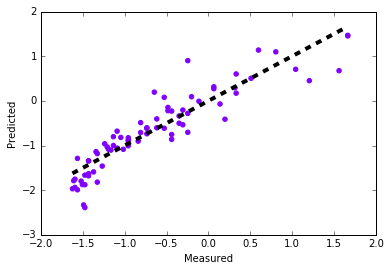

('Group0 MSE: ', 0.12758795163048015)


In [13]:
g0=np.nan_to_num(groups['Group'] == 0)
y0 = y[g0]
pred0 = pred[g0]

fig, ax = plt.subplots()
ax.scatter(y0, pred0, color=cmap((groups['Group'][g0])))
ax.plot([y0.min(), y0.max()], [y0.min(), y0.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group0 MSE: ",  mean_squared_error(y0, pred0))

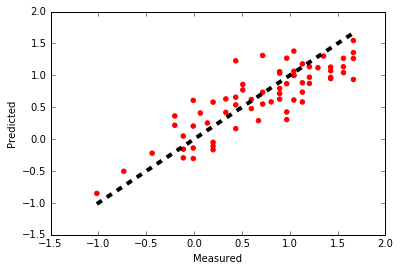

('Group1 MSE: ', 0.11105268567608625)


In [14]:
g1=np.nan_to_num(groups['Group'] == 1)
y1 = y[g1]
pred1 = pred[g1]

fig, ax = plt.subplots()
ax.scatter(y1, pred1, color=cmap((groups['Group'][g1])))
ax.plot([y1.min(), y1.max()], [y1.min(), y1.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()
print("Group1 MSE: ",  mean_squared_error(y1, pred1))

## Data ##
**X:** training data

**y:** true labels 

**pred:** predicted scores from regressor

**pred0:** predictions for group 0

**pred1:** predictions for group 1

**g:** groups indicated by [0, 1]

**results:** tuple (pred_i, label_i, group)

**results0**

**results1**

In [15]:
results = pd.DataFrame()
results['pred'] = pred
results['y'] = y
results['g'] = g.values
results = results.sort('pred')
results0 = results[results['g']==0]
print results0.shape
results1 = results[results['g']==1]
print results1.shape

(75, 3)
(67, 3)


/home/caitlin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [16]:
def scale(df):
    return(df-df.min()) / (df.max()-df.min())
scaled = scale(results['pred'])

## Binning ##
There are many different ways to bin the data:

1. Bin all data then split into groups
2. Split the data first and then bin the data

For (1) the data in each bin will be informative about the fairness of 
all data at that position in the ranking. 

However, depending on the distribution of the groups, some bins may only contain data from one group.

In this case how do we compare the error?

For (2) the data in each bin will be informative about the fairness of the position assigned to the  

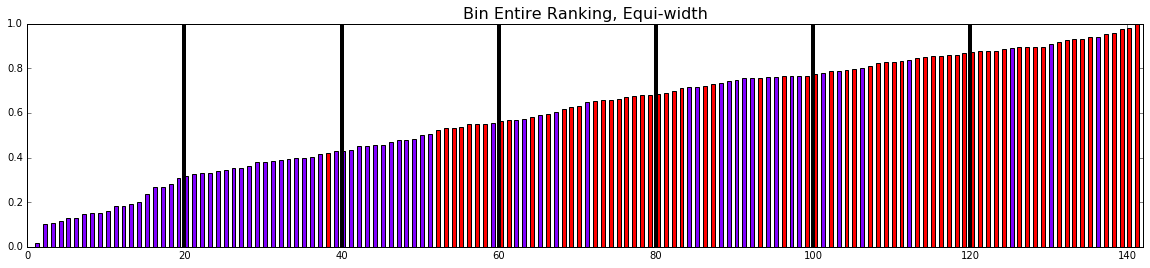

In [17]:
plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(scaled)), scaled, 0.5,color=cmap((groups['Group'])))
ax.set_xlim([0,len(scaled)])
ax.plot([20, 20], [0, scaled.max()], 'k-', lw=4)
ax.plot([40, 40], [0, scaled.max()], 'k-', lw=4)
ax.plot([60, 60], [0, scaled.max()], 'k-', lw=4)
ax.plot([80, 80], [0, scaled.max()], 'k-', lw=4)
ax.plot([100, 100], [0, scaled.max()], 'k-', lw=4)
ax.plot([120, 120], [0, scaled.max()], 'k-', lw=4)
ax.set_title("Bin Entire Ranking, Equi-width", fontsize=16)
plt.show()

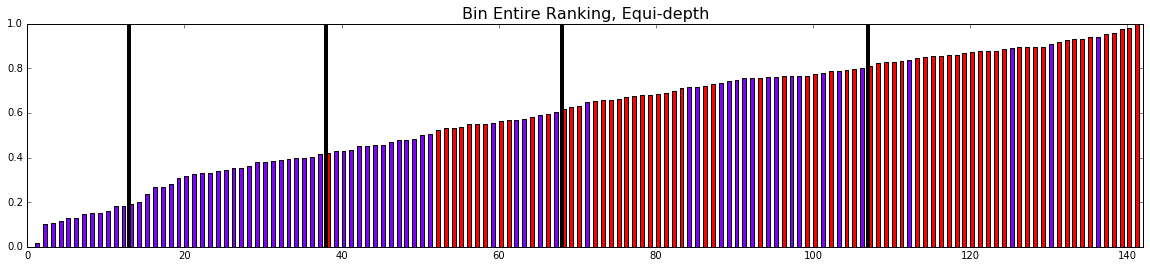

In [18]:


plt.rcParams['figure.figsize'] = (20, 4)
fig, ax = plt.subplots()
ax.bar(range(len(scaled)), scaled, 0.5,color=cmap((groups['Group'])))
ax.set_xlim([0,len(scaled)])
# ax.plot([w, w], [0, scaled.max()], 'k-', lw=4)
ax.plot([13, 13], [0, 1], 'k-', lw=4)#13
ax.plot([38, 38], [0, 1], 'k-', lw=4)#38
ax.plot([68, 68], [0, 1], 'k-', lw=4)#68
ax.plot([107, 107], [0, 1], 'k-', lw=4)#107
ax.set_title("Bin Entire Ranking, Equi-depth", fontsize=16)
plt.show()

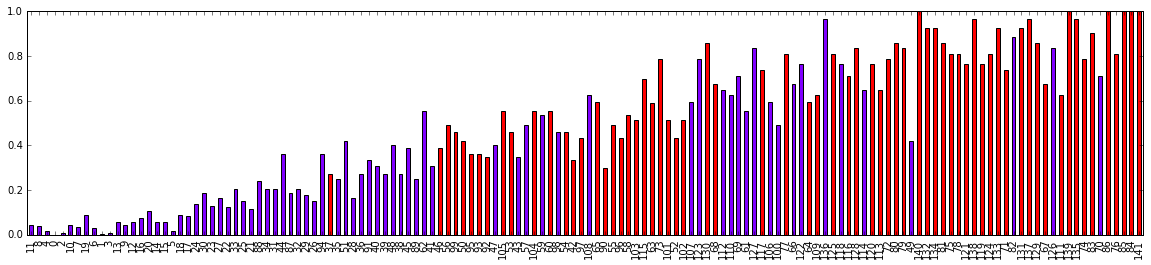

In [19]:
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=1.5, vmax=4.5)
plt.rcParams['figure.figsize'] = (20, 4)
scale(results['y']).plot.bar(color=cmap((groups['Group'])))

In [20]:
# TODO: how to handle empty bin?
# can drop, or set error =0, but that is misleading
# print bins0.shape
# print bins1.shape
# bins1 = bins1[:-1]

In [79]:
#Error metrics

#summary of deviation measures - relates to precision/accuracy?
# https://en.wikipedia.org/wiki/Deviation_(statistics)#Unsigned_or_absolute_deviation
#https://en.wikipedia.org/wiki/Mean_signed_deviation
#signed absolute deviation ?
# https://en.wikipedia.org/wiki/Average_absolute_deviation
#average absolute deviation

def get_ae(vals):
    return np.sum([math.fabs(x[0]-x[1]) for x in vals])

def get_mae(vals):
    m = np.sum([math.fabs(x[0]-x[1]) for x in vals])
    return m/len(vals)


def get_se(vals):
    return np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    
def get_mse(vals):
    m = np.sum([math.pow(x[0]-x[1], 2) for x in vals])
    return m/len(vals)

#overestimate
def get_oe(vals):
    return np.sum([max(0,x[0]-x[1]) for x in vals])

def get_moe(vals):
    m = np.sum([max(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

#underestimate
def get_ue(vals):
    return np.sum([min(0,x[0]-x[1]) for x in vals])

def get_mue(vals):
    m = np.sum([min(0,x[0]-x[1]) for x in vals])
    return m/len(vals)

error_functs = [get_ae, get_mae, get_se, get_mse, get_oe, get_moe, get_ue, get_mue]
##### BIN ERRORS: ###########

def get_bin_width(data, n):
    return (data.max()-data.min())/(n+1)

def get_error_binned_eq_depth_by_group(points, nbins, error=get_mse):
    mse = []
    kf = KFold(points.shape[0], n_folds=nbins)
    print kf
    for rest, bin in kf:
        vals = [points.iloc[i] for i in bin]
        mse.append(error(vals))
    return mse

def get_error_binned_eq_depth_all_data(points, nbins, error=get_mse):
    mse0 = []
    mse1 = []
    kf = KFold(points.shape[0], n_folds=nbins)
    print kf
    for rest, bin in kf:
        vals0 = [points.iloc[i] for i in bin if points.iloc[i]['g'] == 0]
        vals1 = [points.iloc[i] for i in bin if points.iloc[i]['g'] == 1]
        mse0.append(error(vals0))
        mse1.append(error(vals1))
    return mse0,mse1

#This function can bin over all points or each group, depending on min_val and width
def get_error_binned_eq_width(points, min_val, width, nbins, error=get_mse):
    bins=[]
    b=[]
    w = min_val+width
    for i in range(len(points)):
        if(points.iloc[i]['pred'] < w):
            b.append(points.iloc[i])
        else:
            if(len(b)!=0):
                m = error(b)
                bins.append(m)
                b=[]
                w+=width
            else:
                bins.append(0)
                w+=width
    while(len(bins) <= nbins):
        bins.append(0)
    return np.asarray(bins) 

def plot_binned_error(df, error=get_mse):
    indices =np.arange(df.shape[0])
    #Calculate optimal width
    width = 0.3

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.bar(indices-width,df[df.columns[0]],width,color='b',label='-Ymin')
    ax.bar(indices,df[df.columns[1]],width,color='r',label='Ymax')
    ax.set_xlim(left=-1,right=len(df))
    ax.set_xlabel('Bin')
    ax.set_ylabel(error.__name__)
    plt.show()

In [97]:
nbins=10
# bin over all
w = get_bin_width(pred,nbins)
# bin over each group
w0 = get_bin_width(pred0,nbins)
w1 = get_bin_width(pred1,nbins)
print "w: "+str(w)
print "w0: "+str(w0)
print "w1: "+str(w1)

w: 0.357919341667
w0: 0.350834522988
w1: 0.217918725625



Equi-width bins defined over all data


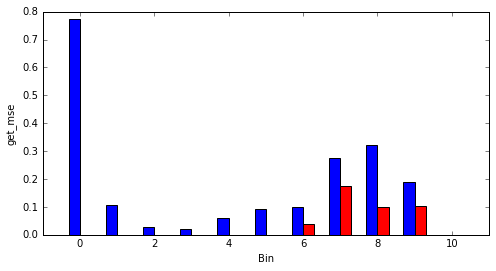

In [98]:
plt.rcParams['figure.figsize'] = (8, 4)
mse_df = pd.DataFrame()

mse_df['mse0'] = get_error_binned_eq_width(results0,results['pred'].min(),w,nbins, error=get_mse)
mse_df['mse1'] = get_error_binned_eq_width(results1,results['pred'].min(),w,nbins, error=get_mse)

print
print "Equi-width bins defined over all data"
plot_binned_error(mse_df,error=get_mse)



Equi-width bins defined over each group


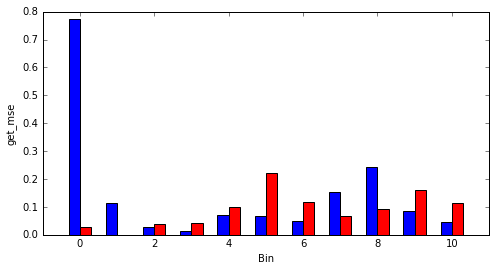

In [99]:
mse_df = pd.DataFrame()

mse_df['mse0'] = get_error_binned_eq_width(results0,results0['pred'].min(),w0, nbins, error=get_mse)
mse_df['mse1'] = get_error_binned_eq_width(results1,results1['pred'].min(),w1, nbins, error=get_mse)
print
print "Equi-width bins defined over each group"
plot_binned_error(mse_df,error=get_mse)

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)

Equi-depth bins defined over all data


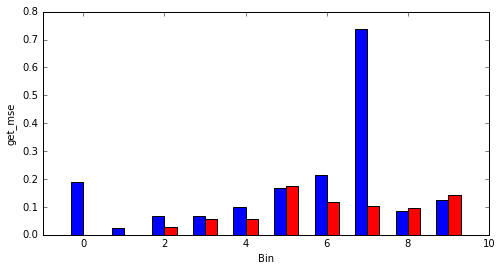

In [100]:
# using equal depth bins
mse_df_depth = pd.DataFrame()
mse0,mse1 = get_error_binned_eq_depth_all_data(results, nbins, error=get_mse)
mse_df_depth['mse0']=mse0
mse_df_depth['mse1']=mse1

print
print "Equi-depth bins defined over all data"
plot_binned_error(mse_df_depth)

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)

Equi-depth bins defined over each group


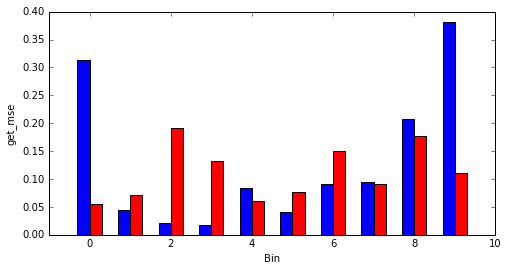

In [101]:
# using equal depth bins
mse_df_depth = pd.DataFrame()
mse_df_depth['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=get_mse)
mse_df_depth['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=get_mse)
# using equal width bins  - which one gives more comparable plot?
print
print "Equi-depth bins defined over each group"
plot_binned_error(mse_df_depth)

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)

Equi-depth bins defined over each group


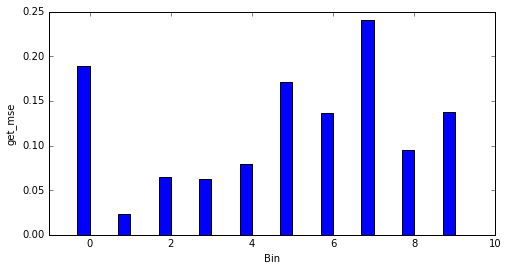

In [102]:
# Look at error over all points
mse_df_depth = pd.DataFrame()
results_no_g=results[['pred','y']]
results_no_g['g']=np.zeros(len(results))
mse0,mse1 = get_error_binned_eq_depth_all_data(results_no_g, nbins, error=get_mse)
mse_df_depth['mse0']=mse0
mse_df_depth['mse1']=mse1
# using equal width bins  - which one gives more comparable plot?
print
print "Equi-depth bins defined over each group"
plot_binned_error(mse_df_depth)


Equi-depth bins defined over each group: 
sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


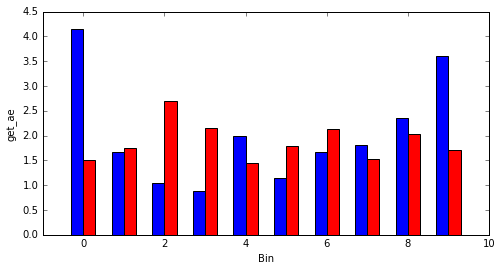

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


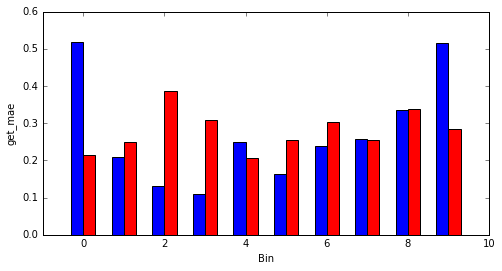

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


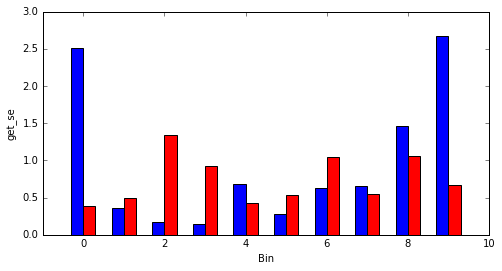

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


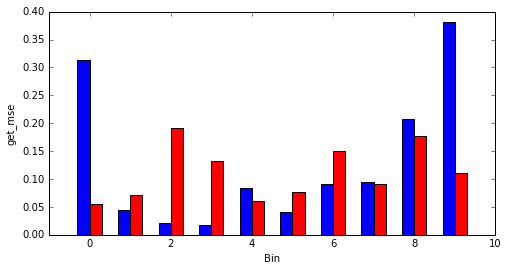

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


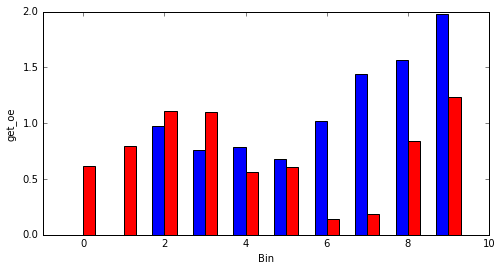

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


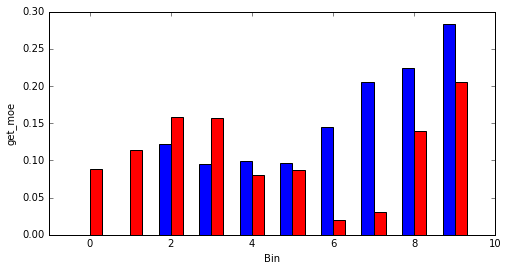

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


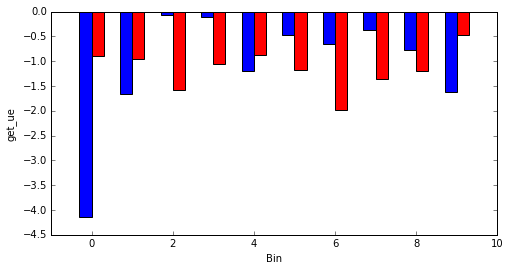

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


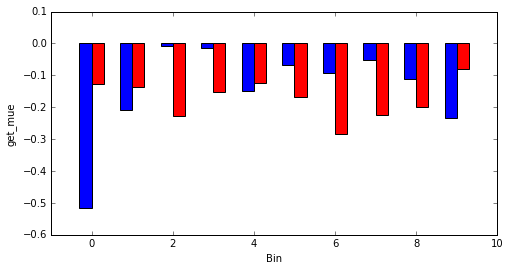

In [104]:
plt.rcParams['figure.figsize'] = (8, 4)

print "Equi-depth bins defined over each group: "
for err in error_functs:
    df = pd.DataFrame()
    df['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=err)
    df['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=err)
    plot_binned_error(df, error=err)

Equi-width bins defined over all data 


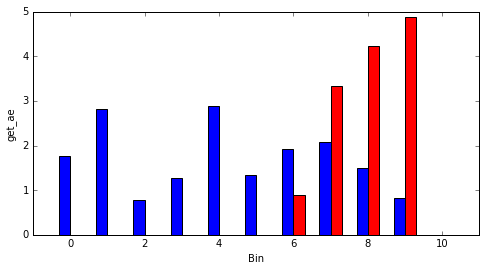

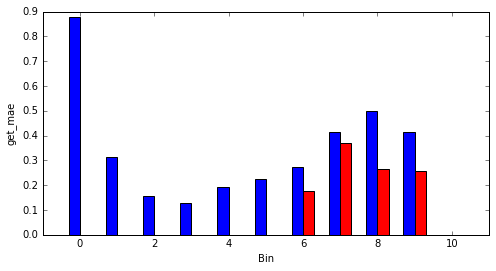

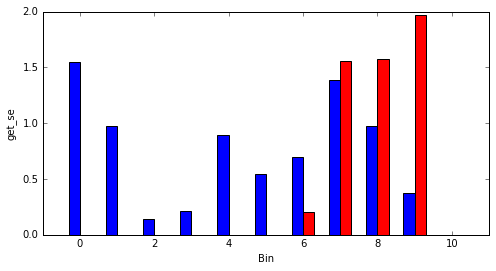

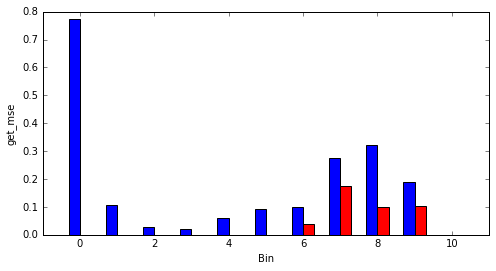

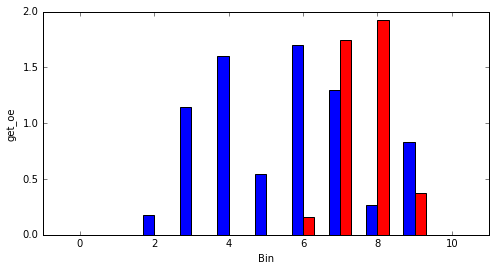

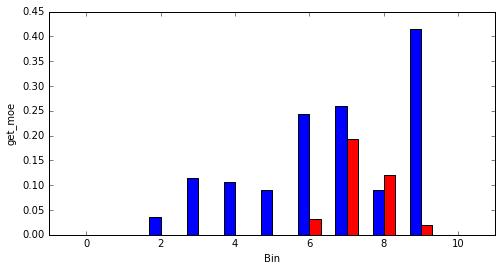

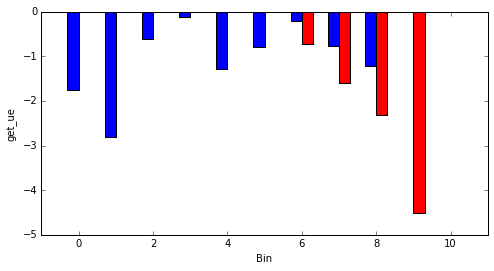

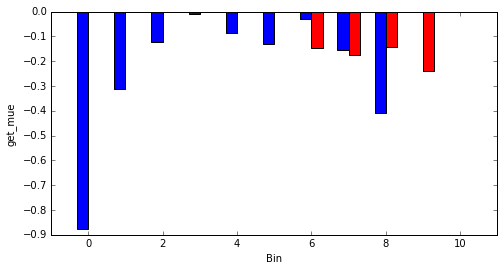


Equi-width bins defined over each group: 



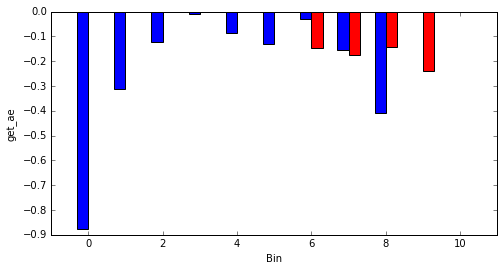

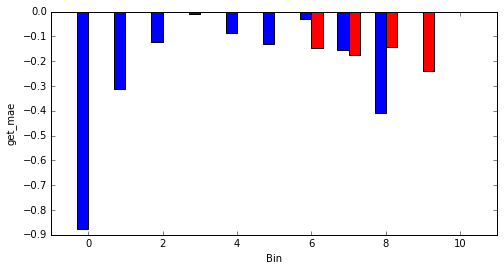

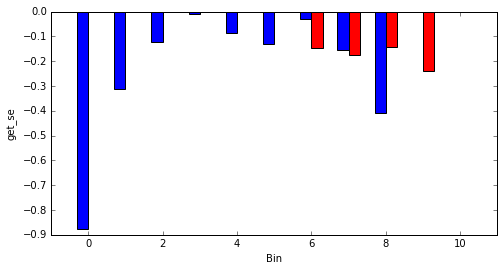

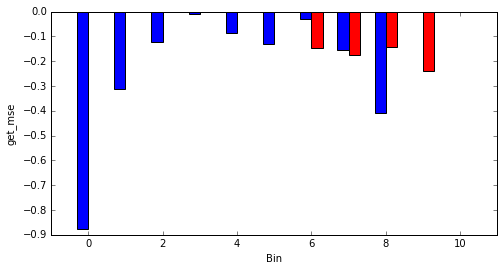

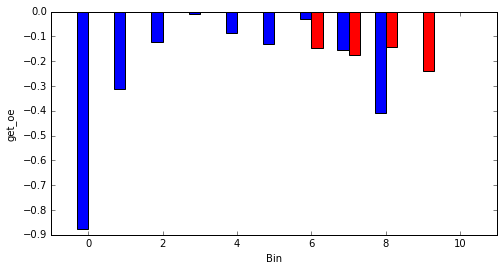

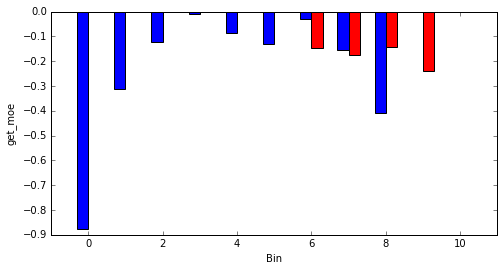

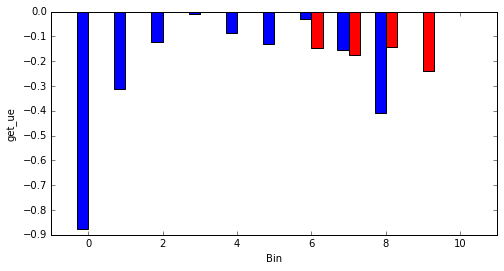

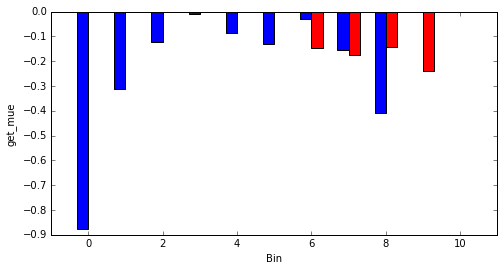


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


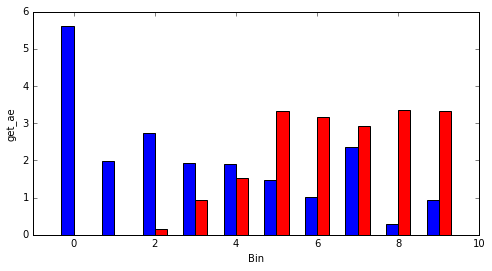

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


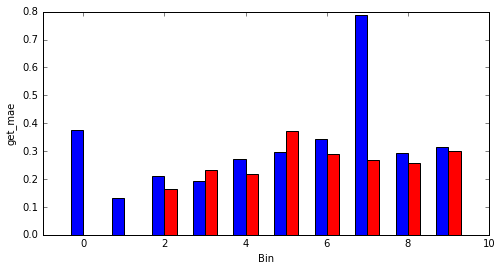

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


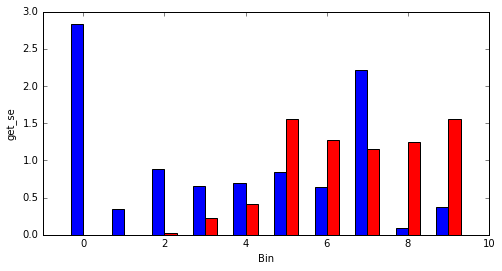

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


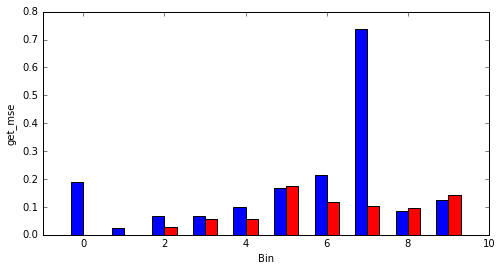

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


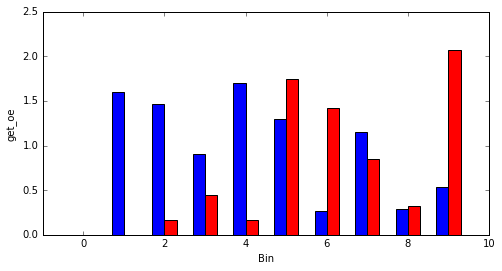

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


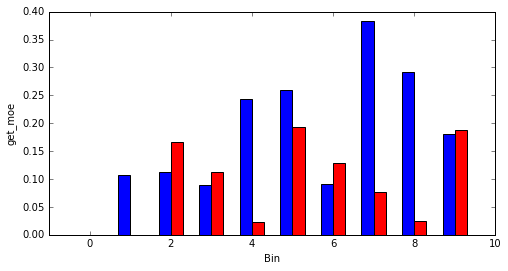

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


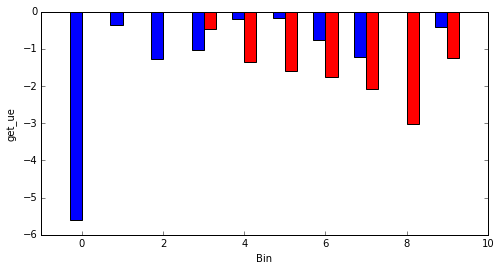

sklearn.cross_validation.KFold(n=142, n_folds=10, shuffle=False, random_state=None)


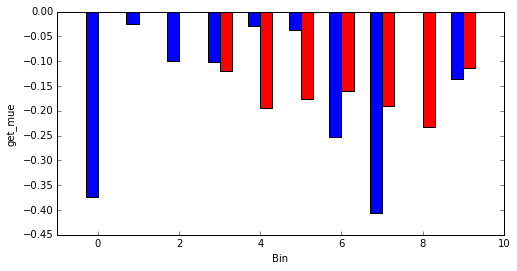


Equi-depth bins defined over each group: 
sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


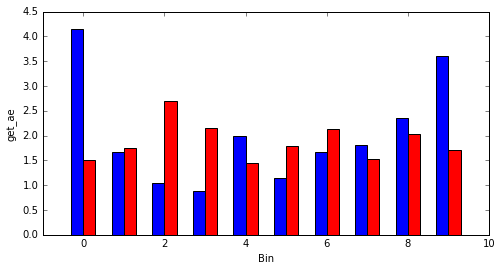

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


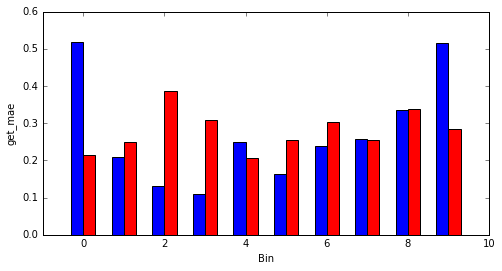

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


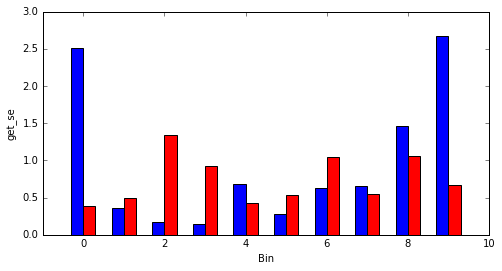

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


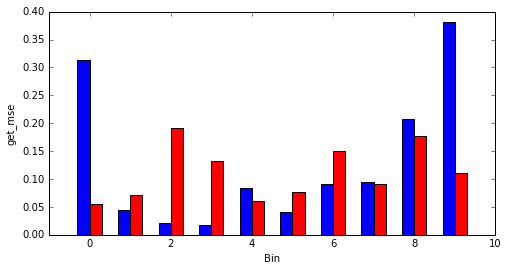

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


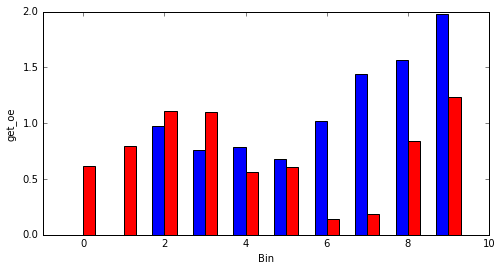

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


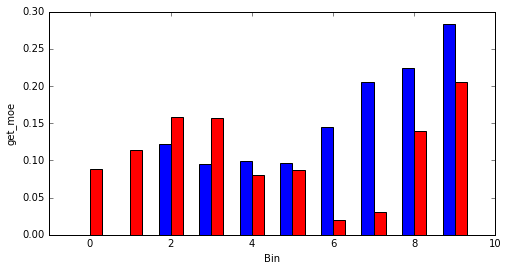

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


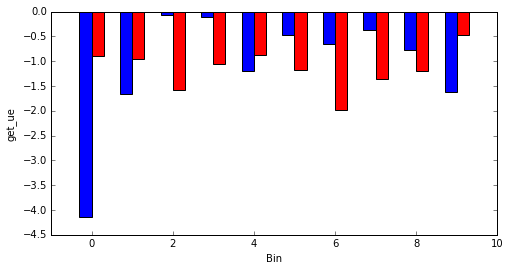

sklearn.cross_validation.KFold(n=75, n_folds=10, shuffle=False, random_state=None)
sklearn.cross_validation.KFold(n=67, n_folds=10, shuffle=False, random_state=None)


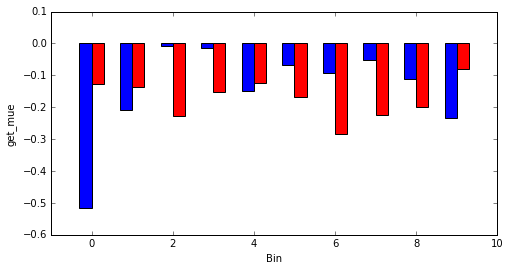

In [103]:
plt.rcParams['figure.figsize'] = (8, 4)

#print all plots of all errors
print "Equi-width bins defined over all data "
for err in error_functs:
    df = pd.DataFrame()
    df['mse0'] = get_error_binned_eq_width(results0,results['pred'].min(),w,nbins, error=err)
    df['mse1'] = get_error_binned_eq_width(results1,results['pred'].min(),w,nbins, error=err)
    plot_binned_error(df, error=err)

print
print "Equi-width bins defined over each group: "
for err in error_functs:
    mse = pd.DataFrame()
    mse['mse0'] = get_error_binned_eq_width(results0,results0['pred'].min(),w0,nbins, error=err)
    mse['mse1'] = get_error_binned_eq_width(results1,results1['pred'].min(),w1,nbins, error=err)
    print
    plot_binned_error(df, error=err)
    
print
print "Equi-depth bins defined over all data: "
for err in error_functs:
    df = pd.DataFrame()
    mse0,mse1 = get_error_binned_eq_depth_all_data(results, nbins, error=err)
    df['mse0']=mse0
    df['mse1']=mse1
    plot_binned_error(df, error=err)

print
print "Equi-depth bins defined over each group: "
for err in error_functs:
    df = pd.DataFrame()
    df['mse0'] = get_error_binned_eq_depth_by_group(results0, nbins, error=err)
    df['mse1'] = get_error_binned_eq_depth_by_group(results1, nbins, error=err)
    plot_binned_error(df, error=err)


Equi-width bins defined over all data 


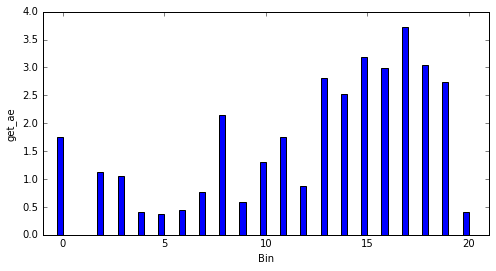


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


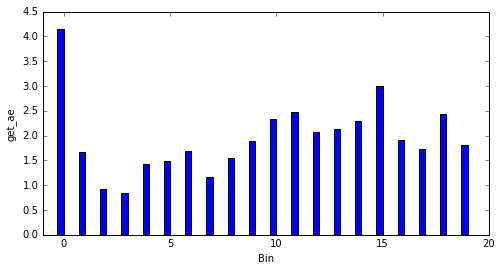


Equi-width bins defined over all data 


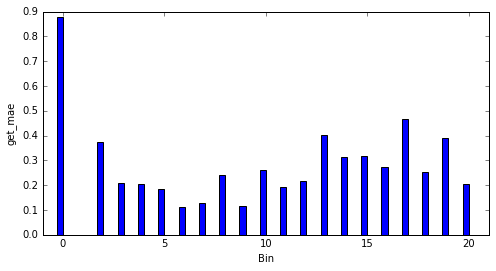


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


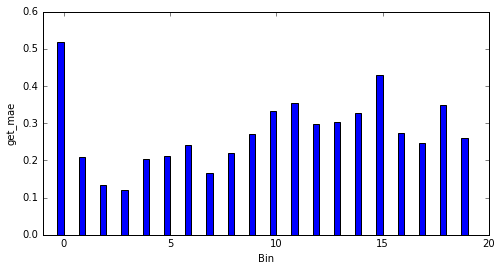


Equi-width bins defined over all data 


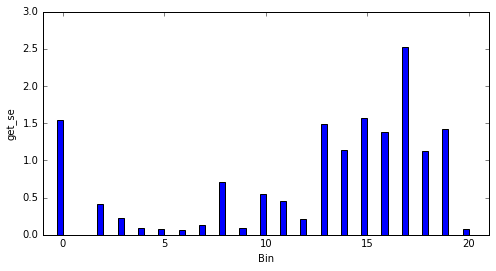


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


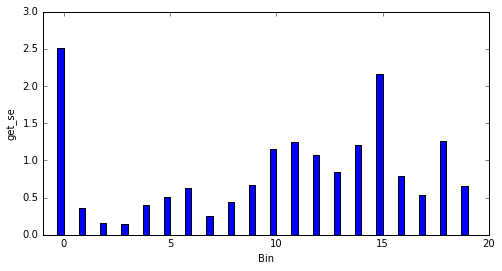


Equi-width bins defined over all data 


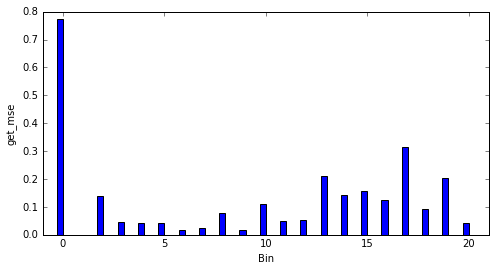


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


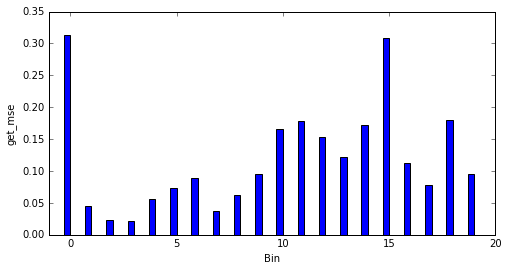


Equi-width bins defined over all data 


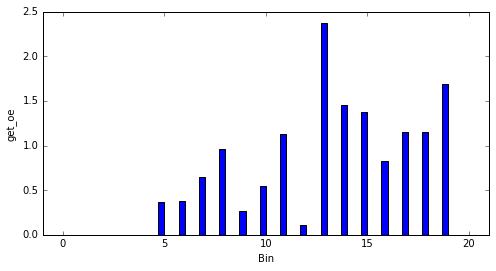


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


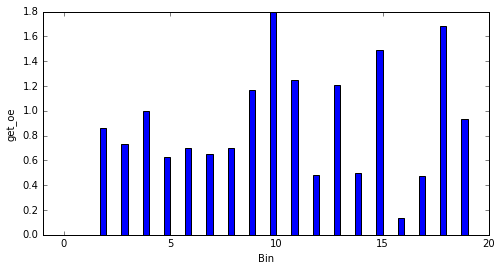


Equi-width bins defined over all data 


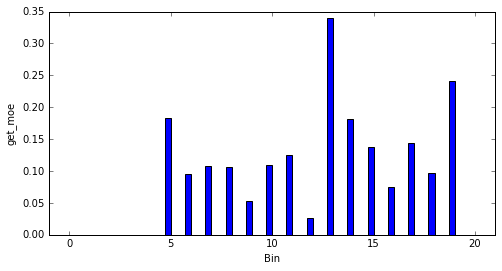


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


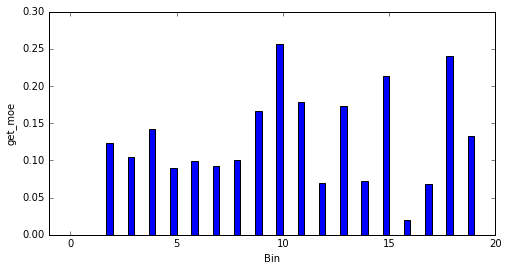


Equi-width bins defined over all data 


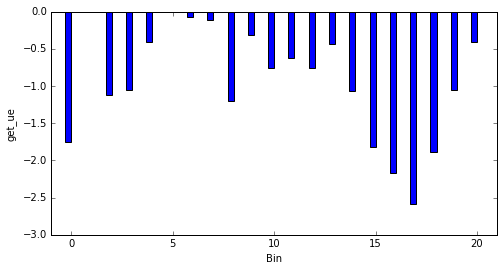


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


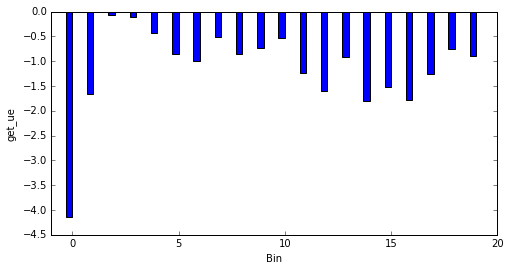


Equi-width bins defined over all data 


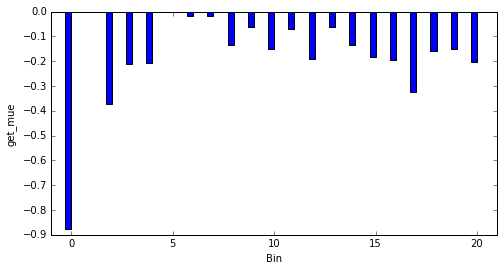


Equi-depth bins defined over all data: 
sklearn.cross_validation.KFold(n=142, n_folds=20, shuffle=False, random_state=None)


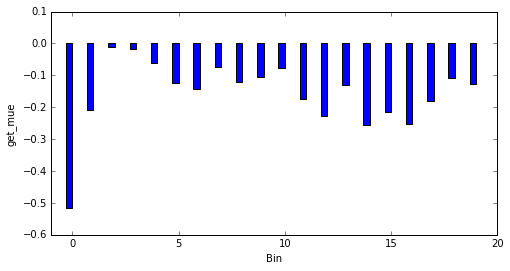

In [96]:
plt.rcParams['figure.figsize'] = (8, 4)

for err in error_functs:
    print
    print "Equi-width bins defined over all data "
    df = pd.DataFrame()
    df['mse0'] = get_error_binned_eq_width(results_no_g,results_no_g['pred'].min(),w,nbins, error=err)
    df["D"] = np.nan
    plot_binned_error(df, error=err)
    
    print
    print "Equi-depth bins defined over all data: "
    df = pd.DataFrame()
    mse0,mse1 = get_error_binned_eq_depth_all_data(results_no_g, nbins, error=err)
    df['mse0']=mse0
    df['mse1']=mse1
    plot_binned_error(df, error=err)

## Moving on to other metrics... ##

In [40]:
#how do differnt error metrics behave?
x=[(2,3),(4,2)]
print get_mse(x)
x=[(1,0.5),(2,3),(4,2)]
print get_mse(x)
print
x=[(2,3),(4,2)]
print get_se(x)
x=[(1,0.5),(2,3),(4,2)]
print get_se(x)
print
x=[(2,3),(4,2)]
print get_mae(x)
x=[(1,0.5),(2,3),(4,2)]
print get_mae(x)
print
x=[(2,3),(4,2)]
print get_ae(x)
x=[(1,0.5),(2,3),(4,2)]
print get_ae(x)
print
x=[(2,3),(4,2)]
print get_moe(x)
x=[(1,0.5),(2,3),(4,2)]
print get_moe(x)
print
x=[(2,3),(4,2)]
print get_oe(x)
x=[(1,0.5),(2,3),(4,2)]
print get_oe(x)
print
x=[(2,3),(4,2)]
print get_mue(x)
x=[(1,0.5),(2,3),(4,2)]
print get_mue(x)
print
x=[(2,3),(4,2)]
print get_ue(x)
x=[(1,0.5),(2,3),(4,2)]
print get_ue(x)

2.5
1.75

5.0
5.25

1.5
1.16666666667

3.0
3.5

1
0.833333333333

2
2.5

-1
-1

-1
-1


In [407]:
overall = pd.DataFrame()
overall['y']=y
overall['pred']=pred
overall['SE'] = pow((overall['y']-overall['pred']),2)

g0 = pd.DataFrame()
g0['y']=y0
g0['pred']=pred0
g0['SE'] = pow((g0['y']-g0['pred']),2)

g1 = pd.DataFrame()
g1['y']=y1
g1['pred']=pred1
g1['SE'] = pow((g1['y']-g1['pred']),2)

overall.sort('pred',inplace=True)
g1.sort('pred',inplace=True)
g1.sort('pred',inplace=True)

In [408]:
# histogram of error is like density estimation - maybe we use a kernel method or something

In [409]:
pd.options.display.float_format = '{:,.2f}'.format

In [410]:
#should be squared error or absolute?
def getOverUnder(df):
    diff = df['y'] - df['pred']
    df.loc[diff <0,'over'] = 0
    df.loc[diff >0,'over'] = pow(diff,2)
    df.loc[diff <0,'under'] = pow(diff,2)
    df.loc[diff >0,'under'] = 0
    df['all'] = pow(diff,2)

In [411]:
getOverUnder(overall)
print("MSE overall: ", overall['all'].mean())
print("Overestimated overall: ", overall['over'].mean())
print("Underestimated overall: ", overall['under'].mean())
print
getOverUnder(g0)
print("MSE Group 2: ", g0['all'].mean())
print("Overestimated g0: ", g0['over'].mean())
print("Underestimated g0: ", g0['under'].mean())
print
getOverUnder(g1)
print("MSE Group 1: ", g1['all'].mean())
print("Overestimated g1: ", g1['over'].mean())
print("Underestimated g1: ", g1['under'].mean())

('MSE overall: ', 0.11978610079284367)
('Overestimated overall: ', 0.07005891155625993)
('Underestimated overall: ', 0.04972718923658371)

('MSE Group 2: ', 0.12758795163048017)
('Overestimated g0: ', 0.07253878394305349)
('Underestimated g0: ', 0.05504916768742666)

('MSE Group 1: ', 0.11105268567608631)
('Overestimated g1: ', 0.06728293500387905)
('Underestimated g1: ', 0.04376975067220722)


In [131]:
def recomputeBins(pred, nbins):
        np.sort(pred)
        binSize=len(pred)/nbins
        bins=[]
        sorted_ind = np.argsort(pred)
        for i in range(len(pred)):
            b=[]
            while(i<binSize):
                b.append(sorted_ind[i])
            bins.append(b)
        return bins

In [ ]:
s 
x =[3,2,8,5,7,4,6,1]


In [ ]:
#not using anymore - but might need actual data points in bin, not just error?
    
# def get_binned_eq_width(points, min_val, width, n):
#     bins=[]
#     b=[]
#     w = min_val+width
#     for i in range(len(points)):
#         if(points[i][0] < w):
#             b.append(points[i])
#         else:
#             m_pred = np.mean([x[0] for x in b])
#             m_y = np.mean([x[1] for x in b])
#             bins.append([m_pred, m_y])
#             b=[]
#             w+=width
#     return np.asarray(bins)  

# def get_binned_eq_depth(points, n_folds=10):
#     pred = []
#     y = []
#     kf = KFold(len(points), n_folds=n_folds)
#     print kf
#     for rest, bin in kf:
#         vals = [points[i] for i in bin]
#         m_pred = np.mean([x[0] for x in vals])
#         m_y = np.mean([x[1] for x in vals])
#         pred.append([m_pred])
#         y.append([m_y])
#     return pred,y





# # bin all data, then divide by width
# print("Group 1: ")
# print get_binned_eq_width(points0, pred.min(), w, nbins)
# print("Group 2")
# print get_binned_eq_width(points1, pred.min(), w, nbins)

# # bin all data, then divide by width
# print("Group 1: ")
# print get_binned_eq_width(points0, pred0.min(), w0, nbins)
# ("Group 2")
# print get_binned_eq_width(points1, pred1.min(), w1, nbins)